In [97]:
import tensorflow as tf
import numpy as np

In [98]:
graph_path = '/data/data/parviz/tmp/retinanet/retinanet_061518/640px_fp32/frozen_retinanet.pb'

In [99]:
retinanet_graph = tf.Graph()
with retinanet_graph.as_default():
    output_graph_def = tf.GraphDef()
    with open(graph_path, "rb") as f:
        output_graph_def.ParseFromString(f.read())
        # Swap out iterator for Placeholder.
        image_tensor = tf.placeholder(tf.float32, shape=(1, 640, 640, 3))
        _ = tf.import_graph_def(output_graph_def, name="", input_map={'IteratorGetNext': image_tensor})

In [100]:
# https://github.com/tensorflow/tpu/blob/6038242542fc8ff21f19d3c04bea214bc907d214/models/official/retinanet/anchors.py#L378

#   Args:
#     cls_outputs: a numpy array with shape [N, num_classes], which stacks class
#       logit outputs on all feature levels. The N is the number of total anchors
#       on all levels. The num_classes is the number of classes predicted by the
#       model.
#     box_outputs: a numpy array with shape [N, 4], which stacks box regression
#       outputs on all feature levels. The N is the number of total anchors on all
#       levels.
#     anchor_boxes: a numpy array with shape [N, 4], which stacks anchors on all
#       feature levels. The N is the number of total anchors on all levels.
#     image_id: an integer number to specify the image id.
        
params = {'num_scales': 3, 'first_lr_drop_step': 960000, 'delta': 0.1, 'quantize': True, 'quantize_weights_bits': 8, 'use_bfloat16': False, 'resnet_depth': 50, 'lr_warmup_step': 120000, 'use_tpu': False, 'quantize_data_bits': 8, 'box_max_detected': 100, 'first_lr_drop_epoch': 8.0, 'val_json_file': '/data/data/coco/annotations/instances_val2017.json', 'second_lr_drop_step': 1320000, 'num_shards': 8, 'momentum': 0.9, 'lr_warmup_init': 6, 'max_level': 7, 'learning_rate': 0.00125, 'aspect_ratios': [(1.0, 1.0), (1.4, 0.7), (0.7, 1.4)], 'is_training_bn': False, 'box_loss_weight': 50.0, 'batch_size': 1, 'quantize_scope': None, 'image_size': 640, 'alpha': 0.25, 'input_rand_hflip': False, 'retinanet_checkpoint': None, 'box_iou_threshold': 0.5, 'num_classes': 90, 'lr_warmup_epoch': 1.0, 'min_level': 3, 'num_examples_per_epoch': 120000, 'finetune': False, 'quantize_delay': 0, 'skip_crowd': False, 'mode': 'eval', 'freeze_resnet_variables': True, 'second_lr_drop_epoch': 11.0, 'anchor_scale': 4.0, 'gamma': 1.5}

def get_detections_tensor(params):
    import anchors
    
    eval_anchors = anchors.Anchors(params['min_level'],
                                     params['max_level'],
                                     params['num_scales'],
                                     params['aspect_ratios'],
                                     params['anchor_scale'],
                                     params['image_size'])
    anchor_labeler = anchors.AnchorLabeler(eval_anchors,
                                     params['num_classes'])

    cls_outputs = {}
    box_outputs = {}

    for level in range(params['min_level'], params['max_level'] + 1):
        #print('level = ' + str(level))
        ## cls_outputs
        tensor_name = 'retinanet/class_net/class-predict'
        if level > 3:
            tensor_name = tensor_name + '_' + str(level-3)
        tensor_name = tensor_name + '/BiasAdd:0'
        #print(tensor_name)
        cls_outputs[level] = tf.get_default_graph().get_tensor_by_name(tensor_name)
        
        ## box_outputs
        tensor_name = 'retinanet/box_net/box-predict'
        if level > 3:
            tensor_name = tensor_name + '_' + str(level-3)
        tensor_name = tensor_name + '/BiasAdd:0'
        #print(tensor_name)
        box_outputs[level] = tf.get_default_graph().get_tensor_by_name(tensor_name)
        
    print(cls_outputs)
    print(box_outputs)
    
    detections = anchor_labeler.generate_detections(cls_outputs, box_outputs, image_id=0)
    print(detections)
    
    return detections


def inference(retinanet_graph, image_np):
    with retinanet_graph.as_default():

        detections = get_detections_tensor(params)

        # Push image through.
        config = tf.ConfigProto(device_count = {'GPU': 0})
        with tf.Session(config=config) as sess:
            tensors = []
            tensors.append(detections)

            outputs = sess.run(tensors, feed_dict={image_tensor: image_np})
            #for output in outputs:
            #    print(output.shape) # (100, 7)
            return outputs[0]

detections_np = inference(retinanet_graph, np.random.random(size=(1,640,640,3)))


{3: <tf.Tensor 'retinanet/class_net/class-predict/BiasAdd:0' shape=(1, 80, 80, 810) dtype=float32>, 4: <tf.Tensor 'retinanet/class_net/class-predict_1/BiasAdd:0' shape=(1, 40, 40, 810) dtype=float32>, 5: <tf.Tensor 'retinanet/class_net/class-predict_2/BiasAdd:0' shape=(1, 20, 20, 810) dtype=float32>, 6: <tf.Tensor 'retinanet/class_net/class-predict_3/BiasAdd:0' shape=(1, 10, 10, 810) dtype=float32>, 7: <tf.Tensor 'retinanet/class_net/class-predict_4/BiasAdd:0' shape=(1, 5, 5, 810) dtype=float32>}
{3: <tf.Tensor 'retinanet/box_net/box-predict/BiasAdd:0' shape=(1, 80, 80, 36) dtype=float32>, 4: <tf.Tensor 'retinanet/box_net/box-predict_1/BiasAdd:0' shape=(1, 40, 40, 36) dtype=float32>, 5: <tf.Tensor 'retinanet/box_net/box-predict_2/BiasAdd:0' shape=(1, 20, 20, 36) dtype=float32>, 6: <tf.Tensor 'retinanet/box_net/box-predict_3/BiasAdd:0' shape=(1, 10, 10, 36) dtype=float32>, 7: <tf.Tensor 'retinanet/box_net/box-predict_4/BiasAdd:0' shape=(1, 5, 5, 36) dtype=float32>}
Tensor("PyFunc:0", dt

In [101]:
import PIL.ImageColor as ImageColor
import PIL.ImageDraw as ImageDraw
import PIL.ImageFont as ImageFont
from PIL import Image

def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color='red',
                               thickness=4,
                               display_str_list=(),
                               use_normalized_coordinates=False):
    """Adds a bounding box to an image.
    Bounding box coordinates can be specified in either absolute (pixel) or
    normalized coordinates by setting the use_normalized_coordinates argument.
    Each string in display_str_list is displayed on a separate line above the
    bounding box in black text on a rectangle filled with the input 'color'.
    If the top of the bounding box extends to the edge of the image, the strings
    are displayed below the bounding box.
    Args:
    image: a PIL.Image object.
    ymin: ymin of bounding box.
    xmin: xmin of bounding box.
    ymax: ymax of bounding box.
    xmax: xmax of bounding box.
    color: color to draw bounding box. Default is red.
    thickness: line thickness. Default value is 4.
    display_str_list: list of strings to display in box
                      (each to be shown on its own line).
    use_normalized_coordinates: If True (default), treat coordinates
      ymin, xmin, ymax, xmax as relative to the image.  Otherwise treat
      coordinates as absolute.
    """
    draw = ImageDraw.Draw(image)
    im_width, im_height = image.size
    (left, right, top, bottom) = (xmin, xmax, ymin, ymax)
    print((left, right, top, bottom))
    draw.line([(left, top), (left, bottom), (right, bottom), (right, top), (left, top)], width=thickness, fill=color)
    try:
        font = ImageFont.truetype('arial.ttf', 24)
    except IOError:
        font = ImageFont.load_default()

    # If the total height of the display strings added to the top of the bounding
    # box exceeds the top of the image, stack the strings below the bounding box
    # instead of above.
    display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
    # Each display_str has a top and bottom margin of 0.05x.
    total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

    if top > total_display_str_height:
        text_bottom = top
    else:
        text_bottom = bottom + total_display_str_height
    # Reverse list and print from bottom to top.
    for display_str in display_str_list[::-1]:
        text_width, text_height = font.getsize(display_str)
        margin = np.ceil(0.05 * text_height)
        draw.rectangle([(left, text_bottom - text_height - 2 * margin), (left + text_width, text_bottom)], fill=color)
        draw.text((left + margin, text_bottom - text_height - margin), display_str, fill='black', font=font)
        text_bottom -= text_height - 2 * margin


(1, 640, 640, 3)


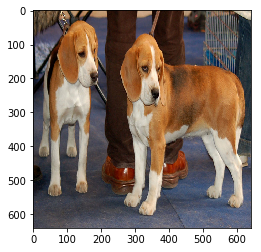

In [110]:
# Show test image.
from matplotlib import pyplot as plt
%matplotlib inline

def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

image_path = 'test_images/image1.jpg'
image = Image.open(image_path)
# the array based representation of the image will be used later in order to prepare the
# result image with boxes and labels on it.
image_np = load_image_into_numpy_array(image)
# Resize image. # pip install --user scikit-image
import skimage
from skimage.transform import resize
image_np = resize(image_np, (640, 640), anti_aliasing=True)
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image_np, axis=0)
print(image_np_expanded.shape)

image_np = image_np_expanded[0,:,:,:]
plt.imshow(image_np)
plt.show()

{3: <tf.Tensor 'retinanet/class_net/class-predict/BiasAdd:0' shape=(1, 80, 80, 810) dtype=float32>, 4: <tf.Tensor 'retinanet/class_net/class-predict_1/BiasAdd:0' shape=(1, 40, 40, 810) dtype=float32>, 5: <tf.Tensor 'retinanet/class_net/class-predict_2/BiasAdd:0' shape=(1, 20, 20, 810) dtype=float32>, 6: <tf.Tensor 'retinanet/class_net/class-predict_3/BiasAdd:0' shape=(1, 10, 10, 810) dtype=float32>, 7: <tf.Tensor 'retinanet/class_net/class-predict_4/BiasAdd:0' shape=(1, 5, 5, 810) dtype=float32>}
{3: <tf.Tensor 'retinanet/box_net/box-predict/BiasAdd:0' shape=(1, 80, 80, 36) dtype=float32>, 4: <tf.Tensor 'retinanet/box_net/box-predict_1/BiasAdd:0' shape=(1, 40, 40, 36) dtype=float32>, 5: <tf.Tensor 'retinanet/box_net/box-predict_2/BiasAdd:0' shape=(1, 20, 20, 36) dtype=float32>, 6: <tf.Tensor 'retinanet/box_net/box-predict_3/BiasAdd:0' shape=(1, 10, 10, 36) dtype=float32>, 7: <tf.Tensor 'retinanet/box_net/box-predict_4/BiasAdd:0' shape=(1, 5, 5, 36) dtype=float32>}
Tensor("PyFunc_6:0", 

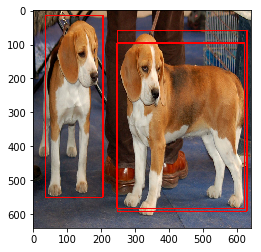

In [111]:
# Push image through network.
detections_np = inference(retinanet_graph, image_np_expanded)

detection_image_np = image_np*255.0
image_pil = Image.fromarray(np.uint8(detection_image_np)).convert('RGB')

#   Returns:
#     detections: detection results in a tensor with each row representing
#       [image_id, x, y, width, height, score, class]
for detection in detections_np:
    image_id, x, y, width, height, score, class_id = detection
    #print((score, x, y, width, height, class_id))
    if score > 0.5:
        print((score, x, y, width, height, class_id))
        draw_bounding_box_on_image(image_pil, y, x, y+height, x+width)
        
#np.copyto(detection_image_np, np.array(image_pil))
plt.imshow(np.asarray(image_pil))